# Лабораторна робота № 4
## Виконала Денисенко Анастасія, ФІ-21

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

### Зчитування зображення і переведення в RGB

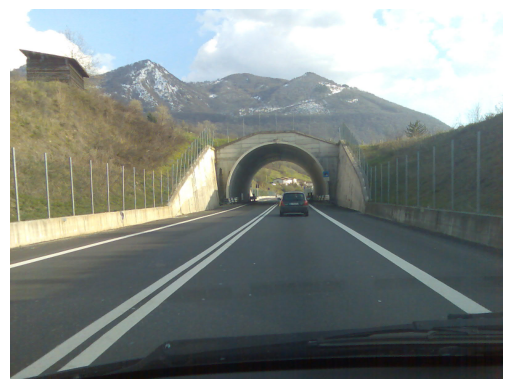

In [2]:
img = cv2.imread('im.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

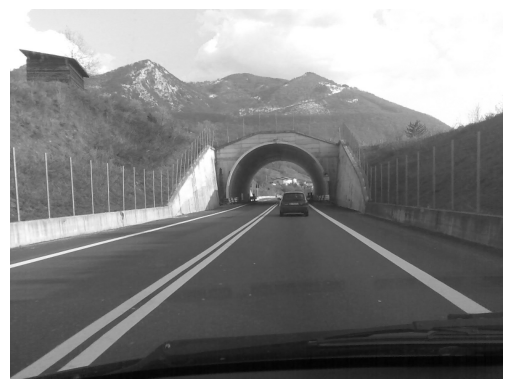

In [4]:
plt.imshow(gray, cmap = 'gray')
plt.axis('off')
plt.show()

### Застосування фільтру з заданою матрицею (згортка)

In [5]:
def apply_filter(im, kernel):
    H, W = im.shape
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2
    
    padded = np.pad(im, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    result = np.zeros((H, W), dtype=np.float32)

    for i in range(H):
        for j in range(W):
            region = padded[i : i+kH, j : j+kW]
            value = np.sum(region * kernel)
            result[i, j] = value

    result = np.clip(result, 0, 255).astype(im.dtype)
    return result

In [6]:
blur = np.array([[0.0751, 0.1238, 0.0751],
    [0.1238, 0.2042, 0.1238],
    [0.0751, 0.1238, 0.0751]])

In [7]:
blurred = apply_filter(gray, blur)

### Застосування розмиття

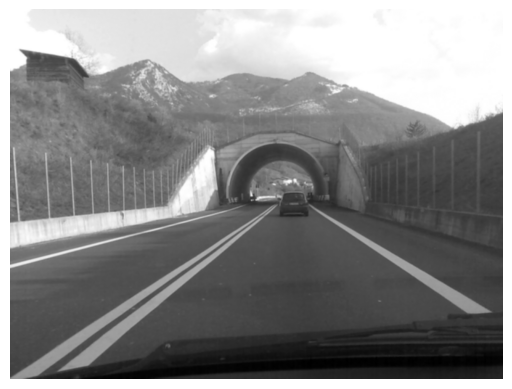

In [8]:
plt.imshow(blurred, cmap = 'gray')
plt.axis('off')
plt.show()

### Фільтр Собеля

In [9]:
def sobel_filter(gray):
    H, W = gray.shape
    padded = np.pad(gray, ((1, 1), (1, 1)), mode='edge')
    Gx = np.zeros((H, W), dtype=np.float32)
    Gy = np.zeros((H, W), dtype=np.float32)
    G  = np.zeros((H, W), dtype=np.float32)
    theta = np.zeros((H, W), dtype=np.float32)
    Kx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])
    Ky = np.array([[-1, -2, -1],
               [0,  0,  0],
               [1,  2,  1]])
    for i in range(H):
        for j in range(W):
            region = padded[i : i+3, j : j+3]
            value_x = np.sum(region * Kx)
            value_y = np.sum(region * Ky)
            Gx[i, j] = value_x
            Gy[i, j] = value_y
            G[i, j] = np.sqrt(value_x**2 + value_y**2)
            theta[i, j] = np.arctan2(value_y, value_x)
    G = np.uint8(G / G.max() * 255)
    return G, theta

In [10]:
sobel_im, theta = sobel_filter(blurred)

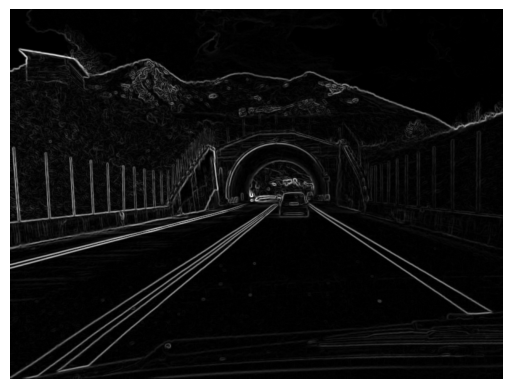

In [11]:
plt.imshow(sobel_im, cmap = 'gray')
plt.axis('off')
plt.show()

### Відрізне пригнічування нижньої межі

In [12]:
def non_max_suppression(G, theta, epsilon = 8):
    H, W = G.shape
    Z = np.zeros((H, W), dtype=np.float32)
    
    angle = np.degrees(theta)
    angle[angle < 0] += 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255
            r = 255
            
            # Горизонтпльно (0°)
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = G[i, j + 1]
                r = G[i, j - 1]
            # Діагонально (45°)
            elif 22.5 <= angle[i, j] < 67.5:
                q = G[i + 1, j - 1]
                r = G[i - 1, j + 1]
            # Вертикально (90°)
            elif 67.5 <= angle[i, j] < 112.5:
                q = G[i + 1, j]
                r = G[i - 1, j]
           # Діагонально (135°)
            elif 112.5 <= angle[i, j] < 157.5:
                q = G[i - 1, j - 1]
                r = G[i + 1, j + 1]

            if (G[i, j] >= q - epsilon) and (G[i, j] >= r - epsilon):
                Z[i, j] = G[i, j]
            else:
                Z[i, j] = 0

    return Z

In [13]:
supp = non_max_suppression(sobel_im, theta)

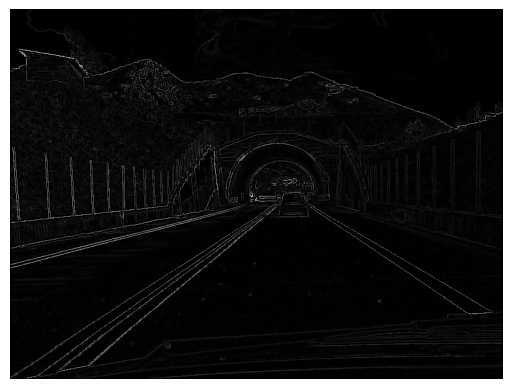

In [14]:
plt.imshow(supp, cmap = 'gray')
plt.axis('off')
plt.show()

### Подвійний поріг

In [15]:
def double_threshold_hysteresis(img, low, high):
    strong = 255
    weak = 50

    res = np.zeros_like(img)
    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img >= low) & (img < high))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # Перетворюємо слабкі кути на силні
    H, W = img.shape
    for i in range(1, H - 1):
        for j in range(1, W - 1):
            if res[i, j] == weak:
                if np.any(res[i-1:i+2, j-1:j+2] == strong):
                    res[i, j] = strong
                else:
                    res[i, j] = 0
    return res

In [16]:
res = double_threshold_hysteresis(supp, 10, 50)

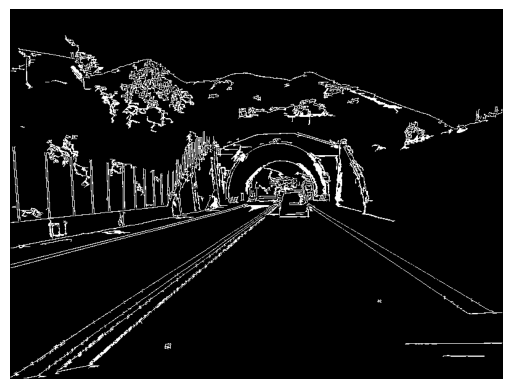

In [17]:
plt.imshow(res, cmap = 'gray')
plt.axis('off')
plt.show()

### Результат

In [18]:
res[0:350] = 0

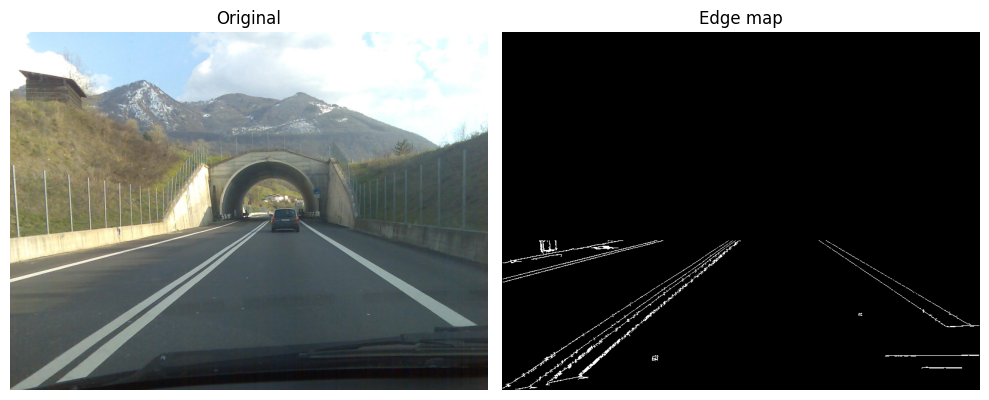

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(res, cmap='gray')
axs[1].set_title("Edge map")
axs[1].axis("off")

plt.tight_layout()
plt.show()

### Перетворення Гафа

In [20]:
def hough_transform(edges):
    height, width = edges.shape
    thetas = np.deg2rad(np.arange(-90, 90))
    diag_len = int(np.hypot(width, height))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    accumulator = np.zeros((2 * diag_len, len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(edges)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            rho = int(round(x * np.cos(thetas[t_idx]) + y * np.sin(thetas[t_idx])) + diag_len)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

In [21]:
accumulator, thetas, rhos = hough_transform(res)

In [22]:
threshold = 100
rhos_idxs, thetas_idxs = np.where(accumulator > threshold)

In [23]:
rhos_values = rhos[rhos_idxs]
thetas_values = thetas[thetas_idxs]

In [24]:
copy = img.copy()
for rho, theta in zip(rhos_values, thetas_values):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    im_lines = cv2.line(copy, (x1, y1), (x2, y2), (255, 0, 0), 1)

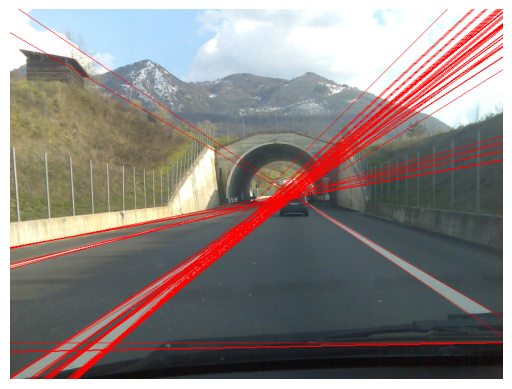

In [25]:
plt.imshow(im_lines)
plt.axis("off")
plt.show()

### Фільтр (усунення горизонтальних прямих)

In [26]:
indexes = []
theta_deg = np.degrees(thetas_values)
for i in range(len(thetas_values)):
    if abs(abs(theta_deg[i]) - 90) > 20:
        indexes.append(i)
filtered_rhos = rhos_values[indexes]
filtered_thetas = thetas_values[indexes]

In [27]:
copy1 = img.copy()
for rho, theta in zip(filtered_rhos, filtered_thetas):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    img_filter_lines = cv2.line(copy1, (x1, y1), (x2, y2), (255, 0, 0), 1)

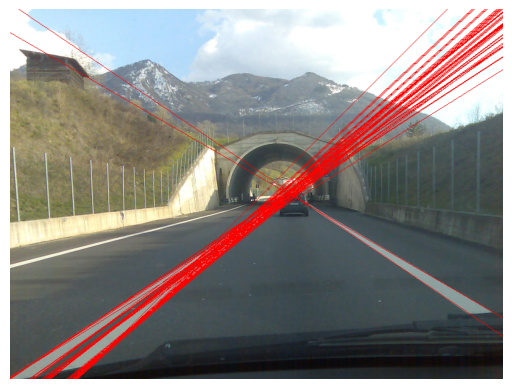

In [28]:
plt.imshow(img_filter_lines)
plt.axis("off")
plt.show()

### Використання алгориму Kmeans

In [29]:
lines = np.column_stack((filtered_rhos, filtered_thetas))

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(lines)
kmeans.cluster_centers_

array([[515.90080755,   0.88637793],
       [-32.51625813,  -1.04719755],
       [  7.50375188,  -0.97738438],
       [508.83133875,   0.91159889],
       [523.30011159,   0.87132207],
       [499.91662498,   0.9424778 ]])

In [32]:
copy2 = img.copy()
for rho, theta in kmeans.cluster_centers_:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    img_kmeans_lines = cv2.line(copy2, (x1, y1), (x2, y2), (255, 0, 0), 1)

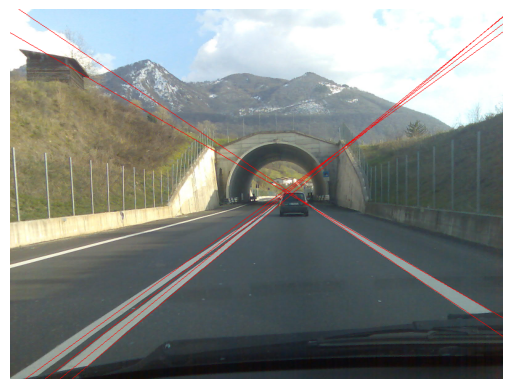

In [33]:
plt.imshow(img_kmeans_lines)
plt.axis("off")
plt.show()